In [ ]:
from google.colab import drive
import requests
import os
import zipfile
import json
import numpy as np
from tqdm import tqdm
import pandas as pd
from imutils import paths
from tabulate import tabulate
import zipfile
from matplotlib import pyplot as plt

In [ ]:
# mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change directory to the Colab Notebooks folder with link to drive of lars
%cd /content/drive/My Drive/MMDL2024/Colab Notebooks/

/content/drive/.shortcut-targets-by-id/1LQRkg9gduygZjO84k_knGQGpy1qEPTp6/Colab Notebooks


In [ ]:
# load json
train_file = open("tallyqa_train.json")
test_file = open("tallyqa_test.json")
train_data = np.array(json.load(train_file))
test_data = np.array(json.load(test_file))
train_file.close()
test_file.close()

# test file has one additional key: "issimple"
# in the following this key is ignored
print(train_data[0].keys())
print(test_data[0].keys())


# concatenate data
data_dict = np.concatenate((train_data, test_data), axis=0)
# get dict keys
data_keys = data_dict[0].keys()
# transform dicts to list and get data array
df = pd.json_normalize(data_dict)
data = df.to_numpy()[:, :6]

dict_keys(['image', 'answer', 'data_source', 'question', 'image_id', 'question_id'])
dict_keys(['image', 'answer', 'data_source', 'question', 'image_id', 'question_id', 'issimple'])


In [ ]:
def file_split_by_name(data):
  coco_train = []
  coco_val = []
  vg_100 = []
  vg_100_2 = []
  unknown = []
  for fname in data:
    foldern, imagen = fname.split("/")
    if foldern == "train2014":
      coco_train.append(fname)
    elif foldern == "val2014":
      coco_val.append(fname)
    elif foldern == "VG_100K":
      vg_100.append(fname)
    elif foldern == "VG_100K_2":
      vg_100_2.append(fname)
    else:
      unknown.append(fname)

  table = [["coco_train", len(coco_train)], ["coco_val", len(coco_val)], ["vg_100", len(vg_100)], ["vg_100_2", len(vg_100_2)], ["unknown", len(unknown)]]
  print(tabulate(table))
  return coco_train, coco_val, vg_100, vg_100_2

# extract all relevant image_names from data
data_image_names = np.unique(data[:, 0])
np.random.shuffle(data_image_names)
print(tabulate([["questions", len(data)], ["images", len(data_image_names)]]))
# get all images names wrt. the datasets which are used in tallyqa
coco_train_files, coco_val_files, vg_100k_files, vg_100k_2_files = file_split_by_name(data_image_names)

---------  ------
questions  287907
images     159432
---------  ------
----------  -----
coco_train  66943
coco_val    32633
vg_100      35270
vg_100_2    24586
unknown         0
----------  -----


In [ ]:
train2014 = list(paths.list_files("coco/train2014/"))
val2014 = list(paths.list_files("coco/val2014/val2014/"))
vg_100k = list(paths.list_files("visual_genome/VG_100K/"))
vg_100k_2 = list(paths.list_files("visual_genome/VG_100K_2"))
table = [["coco_train", len(train2014)], ["coco_val", len(val2014)], ["vg_100", len(vg_100k)], ["vg_100_2", len(vg_100k_2)]]
print("Images found in drive: ")
print(tabulate(table))

Images found in drive: 
----------  -----
coco_train  82783
coco_val    40504
vg_100      64346
vg_100_2    43903
----------  -----


In [ ]:
def search_images(data, drive_data, add_path):
    not_found = 0
    for image_path in tqdm(data):
      image_path = add_path + image_path
      if image_path not in drive_data:
        not_found += 1
        print(image_path)
    if not_found == 0:
      print("All Images found!")
    else:
      print(str(not_found) + " images not found!")

search_images(coco_train_files, train2014, "coco/")
search_images(coco_val_files, val2014, "coco/val2014/")
search_images(vg_100k_files, vg_100k, "visual_genome/")
search_images(vg_100k_2_files, vg_100k_2, "visual_genome/")

100%|██████████| 66943/66943 [02:05<00:00, 533.27it/s]


All Images found!


100%|██████████| 32633/32633 [00:29<00:00, 1107.92it/s]


All Images found!


100%|██████████| 35270/35270 [00:39<00:00, 883.81it/s]


All Images found!


100%|██████████| 24586/24586 [00:13<00:00, 1804.54it/s]

All Images found!


In [ ]:
# extract every question with answer greater then 4
np.random.seed(9929395)
gcd = data[:, 1] >= 6
greater_count_data = data[gcd]
lesser_count_data = []

for i in range(6):
  i_data = data[data[:, 1] == i]
  np.random.shuffle(i_data)
  i_data = i_data[:100 + int(np.exp(0.2*i)*2000)]
  if i == 0:
    lesser_count_data = i_data
  else:
    lesser_count_data = np.concatenate((lesser_count_data, i_data), axis=0)

np.random.shuffle(lesser_count_data)
# create new data array with all answers greater then 4 and 20.000 answers lower then 4
new_data = np.concatenate((greater_count_data, lesser_count_data), axis=0)
# train, val, test split (60, 20, 20)
np.random.shuffle(new_data)

In [ ]:
max_len = len(new_data)
b1 = int(max_len * 0.6)
b2 = int(max_len * 0.8)
new_train_data = new_data[:b1]
new_val_data = new_data[b1:b2]
new_test_data = new_data[b2:]

In [ ]:
unique, counts = np.unique(data[:, 1], return_counts=True)
print(unique)
print(counts)

[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15]
[63261 75604 77246 30268 16887  8306  5550  3122  2638  1521  1188   763
   749   376   326   102]


[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15]
[2100 2542 3083 3744 4551 5536 5550 3122 2638 1521 1188  763  749  376
  326  102]


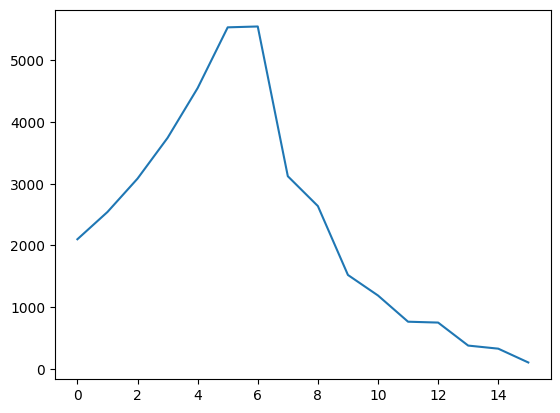

In [ ]:
unique, counts = np.unique(new_data[:, 1], return_counts=True)
print(unique)
print(counts)
len(new_data)
plt.plot(unique, counts)

In [ ]:
def create_json(jdata, file_name):
  # create new json file for new_data
  file = open(file_name, "w")
  json_data = []

  for line in tqdm(jdata):
    tmp_dict = dict()
    if len(line[3]) != 0:
      for i, key in enumerate(data_keys):
          tmp_dict[key] = line[i]
    else:
      continue
    json_data.append(tmp_dict)

  json.dump(json_data, file)

In [ ]:
create_json(new_train_data, "HighCountVQA_train.json")
create_json(new_val_data, "HighCountVQA_val.json")
create_json(new_test_data, "HighCountVQA_test.json")

100%|██████████| 7579/7579 [00:00<00:00, 187994.95it/s]


In [ ]:
create_json(new_data, "HighCountVQA_combined.json")

100%|██████████| 37891/37891 [00:00<00:00, 249300.96it/s]


In [ ]:
create_json(data, "HighCountVQA.json")

100%|██████████| 287907/287907 [00:00<00:00, 412956.08it/s]
